# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле /datasets/autos.csv.

# Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

# Целевой признак:

Price — цена (евро)

## Подготовка данных

In [1]:
#Загрузим библиотеки
import pandas as pd
import lightgbm as ltb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#Загрузим данные и посмотрим инофрмацию о таблице
data = pd.read_csv('/datasets/autos.csv')
print('Информация о таблице:\n')
data.info(5)

#Заменим значения Nan на нули
data = data.fillna(0)
print('\nИнформация о таблице после замены Nan:\n')
data.info(5)

#Вычислим среднее значение цены:
print('Среднее значение цены:', data['Price'].mean())

#Отобразим первые 5 значений столбца Price
print('\nЗначения столбца Price:')
display(data['Price'].head(5))

Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB

Информация о таблице после замены Nan:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368

0      480
1    18300
2     9800
3     1500
4     3600
Name: Price, dtype: int64

# Удаление выбросов

Информация о столбце Price до удаления выбросов:


count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Информация о столбце Price после удаления выбросов:


count    335390.000000
mean       3711.078154
std        3474.706185
min           0.000000
25%        1000.000000
50%        2500.000000
75%        5500.000000
max       14400.000000
Name: Price, dtype: float64

Информация о столбце RegistrationYear до удаления выбросов:


count    335390.000000
mean       2003.919097
std          90.065007
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Информация о столбце RegistrationYear после удаления выбросов:


count    334432.000000
mean       2002.897752
std           6.925599
min        1967.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

Информация о столбце Power до удаления выбросов:


count    334432.000000
mean        106.338855
std         191.265824
min           0.000000
25%          66.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

Информация о столбце Power после удаления выбросов:


count    329261.000000
mean         99.725510
std          55.394515
min           0.000000
25%          65.000000
50%         101.000000
75%         140.000000
max         250.000000
Name: Power, dtype: float64

Информация о столбце Kilometer:


count    329261.000000
mean     130273.643098
std       36171.942825
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Информация о столбце RegistrationMonth:


count    329261.000000
mean          5.685256
std           3.739137
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

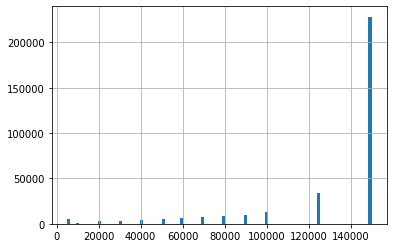

In [2]:
#Удалим выбросы в столбце Price
print('Информация о столбце Price до удаления выбросов:')
display(data['Price'].describe())
Q1 =  data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Price'] > (Q1-1.5*IQR)) & (data['Price'] < (Q3+1.5*IQR))]
print('Информация о столбце Price после удаления выбросов:')
display(data['Price'].describe())

#Удалим выбросы в столбце Price
print('Информация о столбце RegistrationYear до удаления выбросов:')
display(data['RegistrationYear'].describe())
Q1 =  data['RegistrationYear'].quantile(0.25)
Q3 = 2021
IQR = Q3 - Q1
data = data[(data['RegistrationYear'] > (Q1-1.5*IQR)) & (data['RegistrationYear'] < Q3)]
print('Информация о столбце RegistrationYear после удаления выбросов:')
display(data['RegistrationYear'].describe())

#Удалим выбросы в столбце Power
print('Информация о столбце Power до удаления выбросов:')
display(data['Power'].describe())
Q1 =  data['Power'].quantile(0.25)
Q3 = data['Power'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Power'] > (Q1-1.5*IQR)) & (data['Power'] < (Q3+1.5*IQR))]
print('Информация о столбце Power после удаления выбросов:')
display(data['Power'].describe())

#Проверим выбросы в столбце Kilometer
print('Информация о столбце Kilometer:')
display(data['Kilometer'].describe())
data['Kilometer'].hist(bins=100)

#Проверим выбросы в столбце RegistrationMonth
print('Информация о столбце RegistrationMonth:')
display(data['RegistrationMonth'].describe())

## Обучение моделей

# Модель "случайный лес"

In [3]:
#Выделим признаки и целевой признак 
target_forest = data['Price']
features_for = data.drop(['Price', 'DateCrawled','NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1)

#Применим метод OHE для признаков
features_forest = pd.get_dummies(features_for, drop_first=True)

#Выделим 20% тестовых данных из всего объема данных
features_df1, features_test_forest, target_df1, target_test_forest = train_test_split(features_forest, target_forest, test_size=0.20, random_state=12345)

#Разделим отавшиеся 80% данных на тренировочные и валидационные(проверечное). Данные делим в пропорции: 75% от общего числа
#данных - это тренировочные, 25% от общего числа - это валидационные.
features_train_forest, features_valid_forest, target_train_forest, target_valid_forest = train_test_split(features_df1, target_df1, test_size=0.25, random_state=12345)

#Обучим модель "случайный лес"
model = RandomForestRegressor(random_state=12345, n_estimators=3, max_depth=5)#создадим модель и установим гиперпараметры
model.fit(features_train_forest, target_train_forest) #обучим модель на тренировочной выборке
predicted_valid_forest = model.predict(features_valid_forest) #предскажем на валидационной выборке
predicted_valid_forest = pd.Series(predicted_valid_forest)

print("Модели случайны лес на валидационной выборке:\n")
#Вычислим RMSE
RMSE= mean_squared_error(target_valid_forest, predicted_valid_forest)**0.5
print('RMSE случайны лес (n_estimators=3, max_depth=5):', RMSE)

#Изменим гиперпараметры модели "случайный лес"
model = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=10)#создадим модель и установим гиперпараметры
model.fit(features_train_forest, target_train_forest) #обучим модель на тренировочной выборке
predicted_valid_forest = model.predict(features_valid_forest) #предскажем на валидационной выборке
predicted_valid_forest = pd.Series(predicted_valid_forest)
#Вычислим RMSE
RMSE= mean_squared_error(target_valid_forest, predicted_valid_forest)**0.5
print('RMSE случайны лес( n_estimators=5, max_depth=10)):', RMSE)

print("\nМодели случайны лес на тестовой выборке:\n")
#Проверим модель на тестовой выборке:
#Модель № 1
model = RandomForestRegressor(random_state=12345, n_estimators=3, max_depth=5)
model.fit(features_test_forest, target_test_forest) 
predicted_test_forest = model.predict(features_test_forest) 
predicted_test_forest = pd.Series(predicted_test_forest)
#Вычислим RMSE
RMSE= mean_squared_error(target_test_forest, predicted_test_forest)**0.5
print('RMSE случайны лес(n_estimators=3, max_depth=5):', RMSE)

#Модель #2
model = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=10)
model.fit(features_test_forest, target_test_forest) 
predicted_test_forest = model.predict(features_test_forest) 
predicted_test_forest = pd.Series(predicted_test_forest)
#Вычислим RMSE
RMSE= mean_squared_error(target_test_forest, predicted_test_forest)**0.5
print('RMSE случайны лес( n_estimators=5, max_depth=10)):', RMSE)

Модели случайны лес на валидационной выборке:

RMSE случайны лес (n_estimators=3, max_depth=5): 1997.9580509800253
RMSE случайны лес( n_estimators=5, max_depth=10)): 1663.5624049501623

Модели случайны лес на тестовой выборке:

RMSE случайны лес(n_estimators=3, max_depth=5): 1984.3861827028175
RMSE случайны лес( n_estimators=5, max_depth=10)): 1543.6556692933277


# Модель CatBoostRegressor

In [4]:
#Выделим признаки и целевой признак 
target_cat = data['Price']
features_cat = data.drop(['Price', 'DateCrawled','NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1)

#Выделим 20% тестовых данных из всего объема данных
features_df1, features_test_cat, target_df1, target_test_cat = train_test_split(features_cat, target_cat, test_size=0.20, random_state=12345)

#Разделим отавшиеся 80% данных на тренировочные и валидационные(проверечное). Данные делим в пропорции: 75% от общего числа
#данных - это тренировочные, 25% от общего числа - это валидационные.
features_train_cat, features_valid_cat, target_train_cat, target_valid_cat = train_test_split(features_df1, target_df1, test_size=0.25, random_state=12345)

#Выделим категориальные признаки
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated']

print("Модели CatBoost на валидационной выборке:\n")

#Обучим модель "CatBoost"
print('Модель CatBoost(iterations=150)\n')
model = CatBoostRegressor(loss_function='RMSE', random_seed = 12345, iterations=150)
model.fit(features_train_cat, target_train_cat, cat_features=cat_features, verbose=10) #обучим модель
probabilities_valid_cat = model.predict(features_valid_cat)
#Вычислим RMSE
RMSE= mean_squared_error(target_valid_cat, probabilities_valid_cat)**0.5
print('RMSE CatBoost(iterations=150):', RMSE)

#Изменим гиперараметры модели
print('\n Модель CatBoost(iterations=80, learning_rate = 0.1)\n')
model = CatBoostRegressor(loss_function='RMSE', random_seed = 12345, iterations=80, learning_rate = 0.1)
model.fit(features_train_cat, target_train_cat, cat_features=cat_features, verbose=10) #обучим модель
probabilities_valid_cat = model.predict(features_valid_cat)
#Вычислим RMSE
RMSE= mean_squared_error(target_valid_cat, probabilities_valid_cat)**0.5
print('RMSE CatBoost(iterations=80, learning_rate = 0.1):', RMSE)

print("\nМодели CatBoost на тестовой выборке:\n")

#Проверим модели на тестовой выборке:
#Модель № 1
print('Модель CatBoost(iterations=150)\n')
model = CatBoostRegressor(loss_function='RMSE', random_seed = 12345, iterations=150)
model.fit(features_test_cat, target_test_cat, cat_features=cat_features, verbose=10) #обучим модель
probabilities_test_cat = model.predict(features_test_cat)
#Вычислим RMSE
RMSE= mean_squared_error(target_test_cat, probabilities_test_cat)**0.5
print('RMSE CatBoost(iterations=150):', RMSE)

#Модель № 2
print('\n Модель CatBoost(iterations=80, learning_rate = 0.1)\n')
model = CatBoostRegressor(loss_function='RMSE', random_seed = 12345, iterations=80, learning_rate = 0.1)
model.fit(features_test_cat, target_test_cat, cat_features=cat_features, verbose=10) #обучим модель
probabilities_test_cat = model.predict(features_test_cat)
#Вычислим RMSE
RMSE= mean_squared_error(target_test_cat, probabilities_test_cat)**0.5
print('RMSE CatBoost(iterations=80, learning_rate = 0.1):', RMSE)


Модели CatBoost на валидационной выборке:

Модель CatBoost(iterations=150)

0:	learn: 3363.5923717	total: 444ms	remaining: 1m 6s
10:	learn: 2865.1911983	total: 3.97s	remaining: 50.1s
20:	learn: 2514.5432230	total: 7.44s	remaining: 45.7s
30:	learn: 2276.1307325	total: 10.8s	remaining: 41.6s
40:	learn: 2102.0861594	total: 14.2s	remaining: 37.8s
50:	learn: 1984.2268483	total: 17.9s	remaining: 34.7s
60:	learn: 1900.5084130	total: 21.2s	remaining: 30.9s
70:	learn: 1828.4257118	total: 24.5s	remaining: 27.2s
80:	learn: 1778.2365644	total: 27.9s	remaining: 23.7s
90:	learn: 1742.2191371	total: 31.2s	remaining: 20.2s
100:	learn: 1715.1912753	total: 34.4s	remaining: 16.7s
110:	learn: 1695.0513093	total: 37.6s	remaining: 13.2s
120:	learn: 1677.6290697	total: 40.8s	remaining: 9.79s
130:	learn: 1663.0649692	total: 44s	remaining: 6.38s
140:	learn: 1651.5523694	total: 47.2s	remaining: 3.01s
149:	learn: 1642.7392303	total: 50.2s	remaining: 0us
RMSE CatBoost(iterations=150): 1644.930913724311

 Модель C

# Модель LightGBM

In [5]:
#Изменим названия столбцов с заглавных букв в строчные
data.columns = map(str.lower, data.columns)

#Выделим признаки и целевой признак 
target_lgbm = data['price']
features_lgb = data.drop(['price', 'datecrawled','numberofpictures', 'lastseen', 'postalcode', 'datecreated'], axis=1)
features_lgbm = pd.get_dummies(features_lgb, drop_first=True)

#Выделим 20% тестовых данных из всего объема данных
features_df1, features_test_lgbm, target_df1, target_test_lgbm = train_test_split(features_lgbm, target_lgbm, test_size=0.20, random_state=12345)

#Разделим отавшиеся 80% данных на тренировочные и валидационные(проверечное). Данные делим в пропорции: 75% от общего числа
#данных - это тренировочные, 25% от общего числа - это валидационные.
features_train_lgbm, features_valid_lgbm, target_train_lgbm, target_valid_lgbm = train_test_split(features_df1, target_df1, test_size=0.25, random_state=12345)

print("\nМодели LGBMRegressor на валидационной выборке:\n")
#Обучим модель LightGBM
model = LGBMRegressor(num_leaves=20)
model.fit(features_train_lgbm, target_train_lgbm) #обучим модель
probabilities_valid_lgbm = model.predict(features_valid_lgbm)

#Вычислим RMSE
RMSE= mean_squared_error(target_valid_lgbm, probabilities_valid_lgbm)**0.5
print('RMSE LGBMRegressor(num_leaves=20):', RMSE)

#Изменим гиперпараметры
#Обучим модель LightGBM
model = LGBMRegressor(num_leaves=40, learning_rate = 0.1)
model.fit(features_train_lgbm, target_train_lgbm) #обучим модель
probabilities_valid_lgbm = model.predict(features_valid_lgbm)

#Вычислим RMSE
RMSE= mean_squared_error(target_valid_lgbm, probabilities_valid_lgbm)**0.5
print('RMSE LGBMRegressor(num_leaves=40, learning_rate = 0.1):', RMSE)


print("\nМодели LGBMRegressor на тестовой выборке:\n")

#Проверим модели на тестовой выборке:
#Модель № 1
model = LGBMRegressor(num_leaves=20)
model.fit(features_test_lgbm, target_test_lgbm) #обучим модель
probabilities_test_lgbm = model.predict(features_test_lgbm)
#Вычислим RMSE
RMSE= mean_squared_error(target_test_lgbm, probabilities_test_lgbm)**0.5
print('RMSE LGBMRegressor(num_leaves=20):', RMSE)

#Модель № 2
model = LGBMRegressor(num_leaves=40, learning_rate = 0.1)
model.fit(features_test_lgbm, target_test_lgbm) #обучим модель
probabilities_test_lgbm = model.predict(features_test_lgbm)
#Вычислим RMSE
RMSE= mean_squared_error(target_test_lgbm, probabilities_test_lgbm)**0.5
print('RMSE LGBMRegressor(num_leaves=40, learning_rate = 0.1):', RMSE)


Модели LGBMRegressor на валидационной выборке:

RMSE LGBMRegressor(num_leaves=20): 1524.0220829988211
RMSE LGBMRegressor(num_leaves=40, learning_rate = 0.1): 1473.5565573257204

Модели LGBMRegressor на тестовой выборке:

RMSE LGBMRegressor(num_leaves=20): 1507.7171853842667
RMSE LGBMRegressor(num_leaves=40, learning_rate = 0.1): 1435.213481503152


## Анализ моделей

# Модель "случайный лес". Время обучения

In [6]:
%%time
model = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=10)#создадим модель и установим гиперпараметры
model.fit(features_train_forest, target_train_forest) #обучим модель на тренировочной выборке

CPU times: user 21.2 s, sys: 258 ms, total: 21.5 s
Wall time: 21.6 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=12345, verbose=0,
                      warm_start=False)

# Модель "случайный лес". Скорость предсказания

In [7]:
%%time
predicted_valid_forest = model.predict(features_valid_forest) #предскажем на валидационной выборке

CPU times: user 132 ms, sys: 85.3 ms, total: 217 ms
Wall time: 232 ms


# Модель CatBoostRegressor. Время обучения

In [8]:
%%time
model = CatBoostRegressor(loss_function='RMSE', random_seed = 12345, iterations=80, learning_rate = 0.1)
model.fit(features_train_cat, target_train_cat, cat_features=cat_features, verbose=10) #обучим модель

0:	learn: 3224.5186848	total: 351ms	remaining: 27.8s
10:	learn: 2152.1541516	total: 3.95s	remaining: 24.8s
20:	learn: 1828.1311208	total: 7.61s	remaining: 21.4s
30:	learn: 1706.0331789	total: 11s	remaining: 17.4s
40:	learn: 1654.8554960	total: 14.5s	remaining: 13.8s
50:	learn: 1627.0750790	total: 17.8s	remaining: 10.1s
60:	learn: 1605.6167040	total: 21.2s	remaining: 6.6s
70:	learn: 1588.2424991	total: 24.7s	remaining: 3.13s
79:	learn: 1572.8595927	total: 27.8s	remaining: 0us
CPU times: user 24 s, sys: 5.06 s, total: 29 s
Wall time: 30.5 s


# Модель CatBoostRegressor. Скорость предсказания

In [9]:
%%time
probabilities_valid_cat = model.predict(features_valid_cat)

CPU times: user 243 ms, sys: 30.2 ms, total: 273 ms
Wall time: 269 ms


# Модель LightGBM. Время обучения

In [10]:
%%time
model = LGBMRegressor(num_leaves=40, learning_rate = 0.1)
model.fit(features_train_lgbm, target_train_lgbm)

CPU times: user 8min 36s, sys: 3.48 s, total: 8min 40s
Wall time: 8min 43s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=40, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Модель LightGBM. Скорость предсказания

In [11]:
%%time
probabilities_valid_lgbm = model.predict(features_valid_lgbm)

CPU times: user 1.1 s, sys: 67.5 ms, total: 1.17 s
Wall time: 1.19 s


## Вывод:

### По проекту было выполнено:

- Загружены данные и выполнена их предоьработка 

- Обучены три разных модели (Случайный лес, CatBoostRegressor и LightGBM)

- Проверена скорость обучения, предсказания и качество модели. 

### Лучшая модель по качеству:

- это LGBMRegressor(num_leaves=40, learning_rate = 0.1): 1435.213481503152

- на втором месте "Случаный лес" (RMSE случайны лес( n_estimators=3)): 1543.6556692933277

- а на третьем CatBoost (RMSE CatBoost(iterations=80, learning_rate = 0.1):  1576.9069234690216

### Лучшая модель по скорости обучения:

- это CatBoost - Wall time: 27.5 s

- на втором 'Случайный лес' - Wall time: 28.5 s

- на третьем LGBMRegressor  - Wall time: 28.7 s
 
### Лучшая модель по скорости предсказания:

- на первом CatBoost - Wall time: 275 ms

- на втором 'Случайный лес' - Wall time: 283 ms

- на тертьем LGBMRegressor  - Wall time: 1.78 s

Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.
Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.
Для задач, не требующих сильной предобработки и заготовки данных CatBoostRegressor может показать себя очень хорошо.